In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import math
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Create Environment

In [17]:
class SmartCharging(gym.Env):

    def __init__(self, render_mode=None):

        # action - kw: zero(0) - 0, low(1) - 7, medium(2) - 14, high(3) - 22
        self.actions_to_kw = [0, 7, 14, 22]
        self.action_space = spaces.Discrete(4)
        
        # average EV capacity 72 kWh: https://ev-database.org/cheatsheet/useable-battery-capacity-electric-car
        self.battery_capacity = 72
        # time steps: 0 - 2 p.m., 1 - 2:15 p.m., ... , 7 - 3:45 p.m., 8 - 4 p.m.
        self.time_step = 0
        self.observation_space = np.array([spaces.Box(0, self.battery_capacity, shape=(1,)), spaces.Box(0, 8, shape=(1,))])
        
        # 15 minute charging slots
        self.time_slot = 0.25
        # random start battery status in kWh to simulate energy left from previous shift
        self.battery_status = random.randint(0,self.battery_capacity)

    def _get_obs(self):
        #return {"battery status": self.battery_status, "time step": self.time_step}
        return np.array([self.battery_status, self.time_step])

    def step(self, action):

        terminated = False
        
        if self.time_step == 8:
            
            energy_demand = np.random.normal(loc=30, scale=5)
            penalty_factor = 10
            
            if energy_demand > self.battery_status:
                
                self.battery_status = 0
                # to really penalize running out of energy, make penalty as high as maximum charging costs. Still open what time coefficient is
                sum_of_time_coeffs = 2
                reward = (-1) * sum_of_time_coeffs * math.exp(self.actions_to_kw[3]) * penalty_factor
            else:
                
                self.battery_status -= energy_demand
                reward = 0

            terminated = True
        else:
            
            charged_kWh = self.time_slot * self.actions_to_kw[action]
            time_coeff = self.time_slot # open question: What does the coefficient represent?
            
            if self.battery_status + charged_kWh > self.battery_capacity:
                
                charged_kWh = self.battery_capacity - self.battery_status
                time_coeff = charged_kWh/self.actions_to_kw[action]
                
                
            self.battery_status += charged_kWh
            self.time_step += 1
            
            reward = (-1) * time_coeff * math.exp(self.actions_to_kw[action])
        
        return self._get_obs(), reward, terminated

    def reset(self, seed=None, options=None):
        
        self.battery_status = random.randint(0,self.battery_capacity)
        self.time_step = 0
        
        return self._get_obs()
        

### Deep Q-Network

In [18]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model


class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=10000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_eval.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)
        

# Utilities
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

[60  0]
1/1 [==============================] - 0s 81ms/step
episode:  0 score: -1879.94  average score -1879.94
[37  0]
1/1 [==============================] - 0s 64ms/step
episode:  1 score: -2193.27  average score -2036.60
[12  0]
1/1 [==============================] - 0s 52ms/step
episode:  2 score: -71698259115.90  average score -23899421063.04
[1 0]
1/1 [==============================] - 0s 78ms/step
episode:  3 score: -71698257472.45  average score -35849130165.39
[42  0]
1/1 [==============================] - 0s 63ms/step
episode:  4 score: -2193.27  average score -28679304570.96
[10  0]
1/1 [==============================] - 0s 79ms/step
episode:  5 score: -71698259115.90  average score -35849130328.45
[22  0]
1/1 [==============================] - 0s 65ms/step
episode:  6 score: -71698259115.90  average score -40970434440.95
[16  0]
2/2 [==============================] - 0s 10ms/step
episode:  7 score: -71698257472.45  average score -44811412319.88
[60  0]
2/2 [================

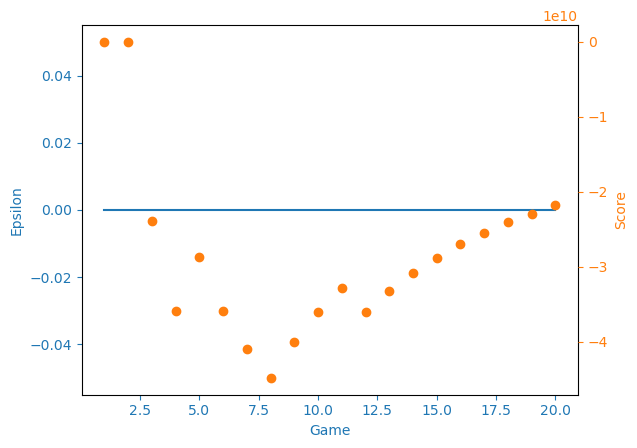

In [21]:

if __name__ == '__main__':
    
    env = SmartCharging()
    
    lr = 0.0005
    n_games = 20
    agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=2,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

#     agent.load_model()
    scores = []
    eps_history = []

    #env = wrappers.Monitor(env, "tmp/lunar-lander-6",
    #                         video_callable=lambda episode_id: True, force=True)

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()#[0]
        print(observation)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = 'smartCharging.png'

    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)

In [22]:
# check target network seltener updaten?
# zweites modifiziertes Model
# Algo für automatisierung verschiedene Parameter (Epsilons, Gamma)

# Q-Learning implementieren